## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE
tf.config.list_physical_devices('GPU')

c:\Users\Mateus\Downloads\super_res\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[]

## Download the training dataset


In [3]:
# Storing on main memory

# # Download DIV2K from TF Datasets
# # Using bicubic 4x degradation type
# div2k_data = tfds.image.Div2k(config="bicubic_x4")
# div2k_data.download_and_prepare()

# # Taking train data from div2k_data object
# train = div2k_data.as_dataset(split="train", as_supervised=True)
# train_cache = train.cache()
# # Validation data
# val = div2k_data.as_dataset(split="validation", as_supervised=True)
# val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  25%|██▌       | 1/4 [01:12<03:32, 70.90s/ url]

Dl Completed...:  25%|██▌       | 1/4 [01:13<03:32, 70.90s/ url]

Dl Completed...:  25%|██▌       | 1/4 [01:29<03:32, 70.90s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:36<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:37<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:38<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:40<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:41<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:42<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:43<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:44<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:45<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [02:46<02:19, 69.64s/ url]

Dl Completed...:  50%|█████     | 2/4 [03:00<02:19, 69.64s/ url]

Dl Completed...:  75%|███████▌  | 3/

In [2]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Define file paths for caching
train_cache_path = r"C:\Users\Mateus\Downloads\super_res\cache\train"
val_cache_path = r"C:\Users\Mateus\Downloads\super_res\cache\train"

# Taking train data from div2k_data object and cache it to the specified path
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache(train_cache_path)

# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache(val_cache_path)


EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 4/4 [1:37:37<00:00, 1451.56s/ url]

Dl Completed...: 100%|██████████| 4/4 [1:37:38<00:00, 1451.56s/ url]

Dl Completed...: 100%|██████████| 4/4 [1:37:39<00:00, 1451.56s/ url]

Dl Completed...: 100%|██████████| 4/4 [1:37:40<00:00, 1451.56s/ url]

Dl Completed...: 100%|██████████| 4/4 [1:37:41<00:00, 1451.56s/ url]

Dl Completed...: 100%|██████████| 4/4 [1:37:41<00:00, 1465.47s/ url]


Dataset div2k downloaded and prepared to C:\Users\Mateus\tensorflow_datasets\div2k\bicubic_x4\2.0.0. Subsequent calls will reuse this data.


## Flip, crop and resize images


In [10]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

# I am changing hr_crop_size from 96 to 32 how John Forest had recommended.
def random_crop(lowres_img, highres_img, hr_crop_size=32, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

## Prepare a `tf.data.Dataset` object

In [11]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)


## Visualize the data

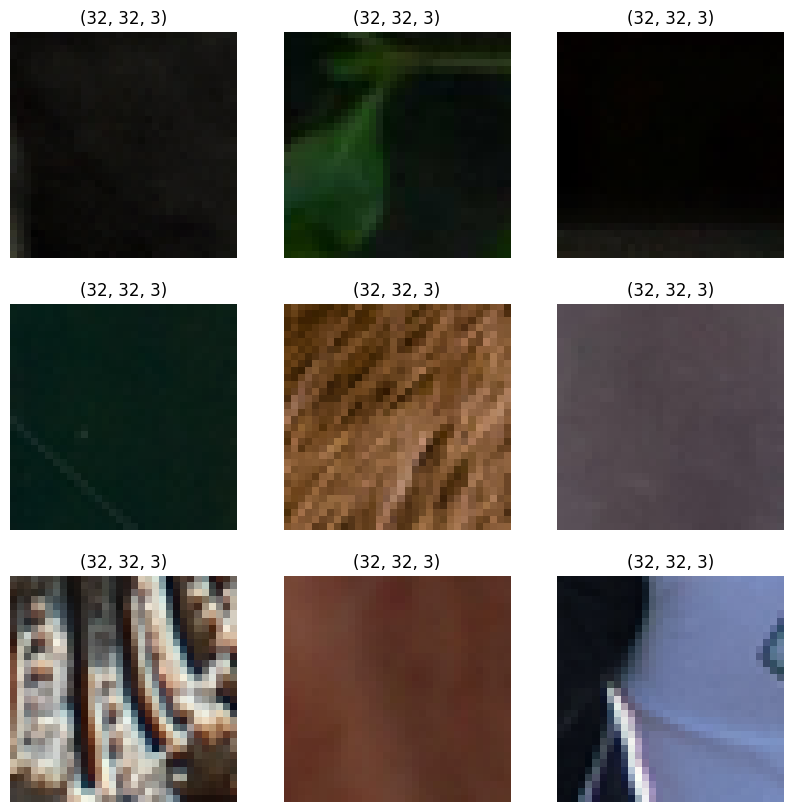

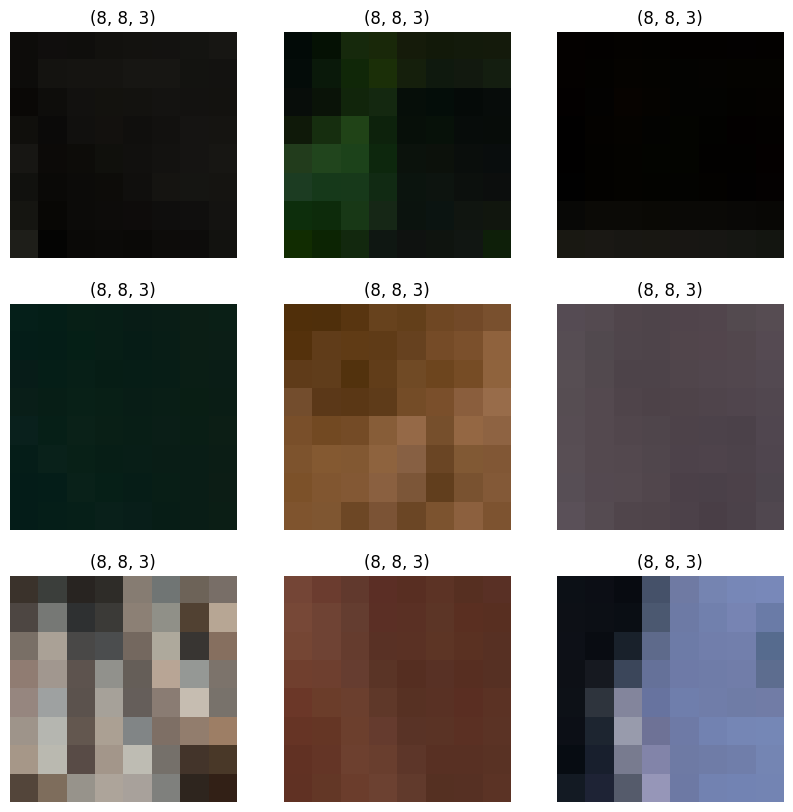

In [12]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

## Build the model

In [13]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

## Train the model

In [14]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100
200/200 [==============================] - 232s 1s/step - loss: 23.4460 - PSNR: 21.8795 - val_loss: 13.3443 - val_PSNR: 26.5355
Epoch 2/100
200/200 [==============================] - 100s 502ms/step - loss: 12.2521 - PSNR: 26.4217 - val_loss: 10.7450 - val_PSNR: 22.4648
Epoch 3/100
200/200 [==============================] - 100s 501ms/step - loss: 10.5103 - PSNR: 28.1209 - val_loss: 9.0739 - val_PSNR: 34.1931
Epoch 4/100
200/200 [==============================] - 100s 502ms/step - loss: 9.8549 - PSNR: 29.0705 - val_loss: 9.2799 - val_PSNR: 35.4201
Epoch 5/100
200/200 [==============================] - 99s 498ms/step - loss: 9.4726 - PSNR: 30.1558 - val_loss: 8.1296 - val_PSNR: 29.5139
Epoch 6/100
200/200 [==============================] - 100s 499ms/step - loss: 8.9515 - PSNR: 29.8310 - val_loss: 8.2184 - val_PSNR: 30.0669
Epoch 7/100
200/200 [==============================] - 99s 496ms/step - loss: 8.3699 - PSNR: 32.4218 - val_loss: 8.0651 - val_PSNR: 35.8625
Epoch 8/100
2

## Run inference on new images and plot the results

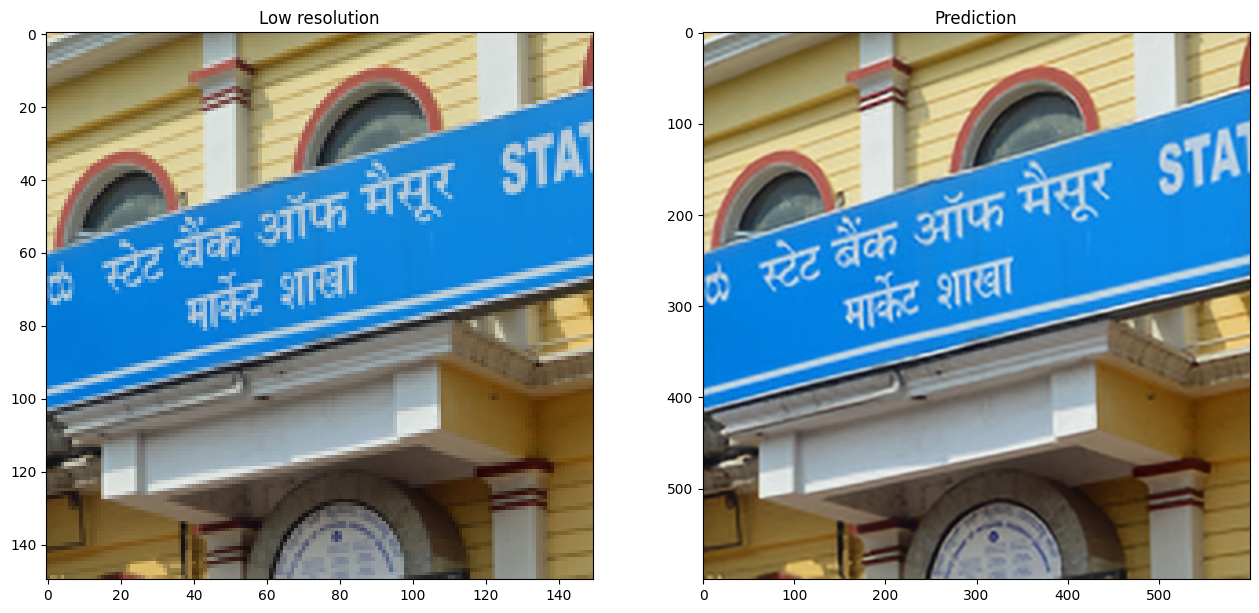

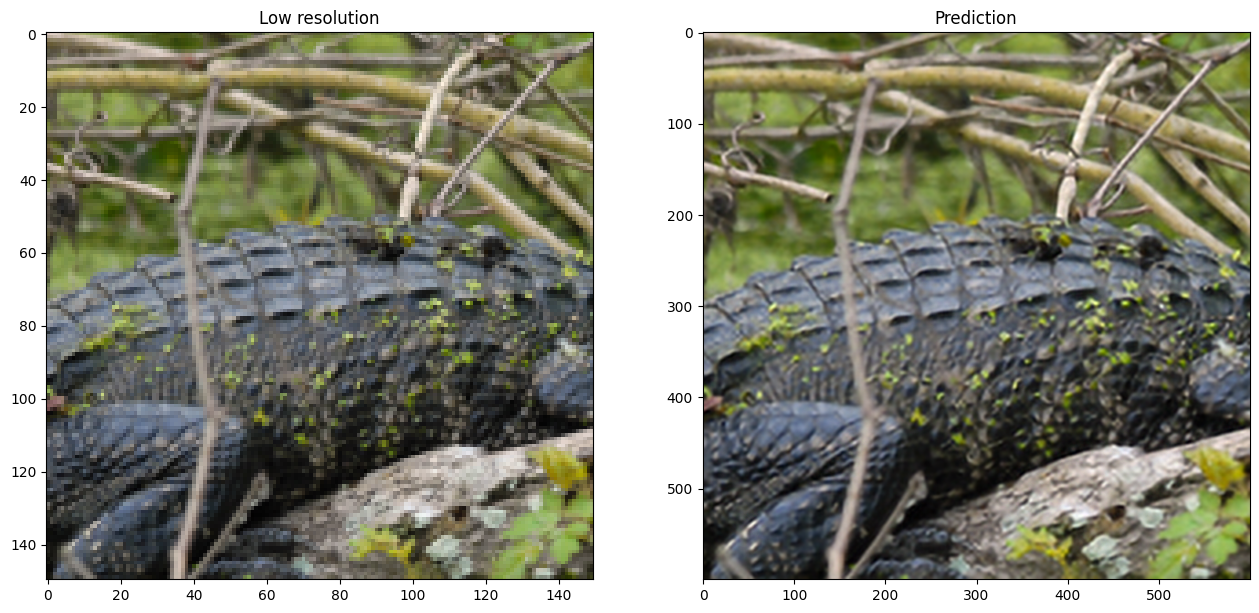

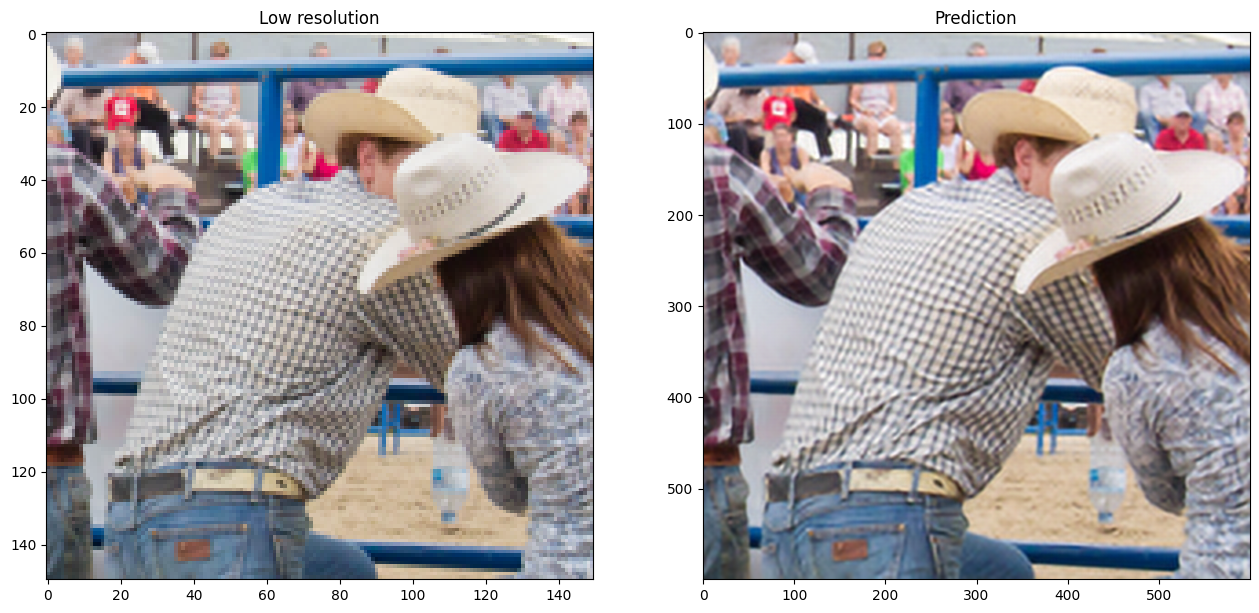

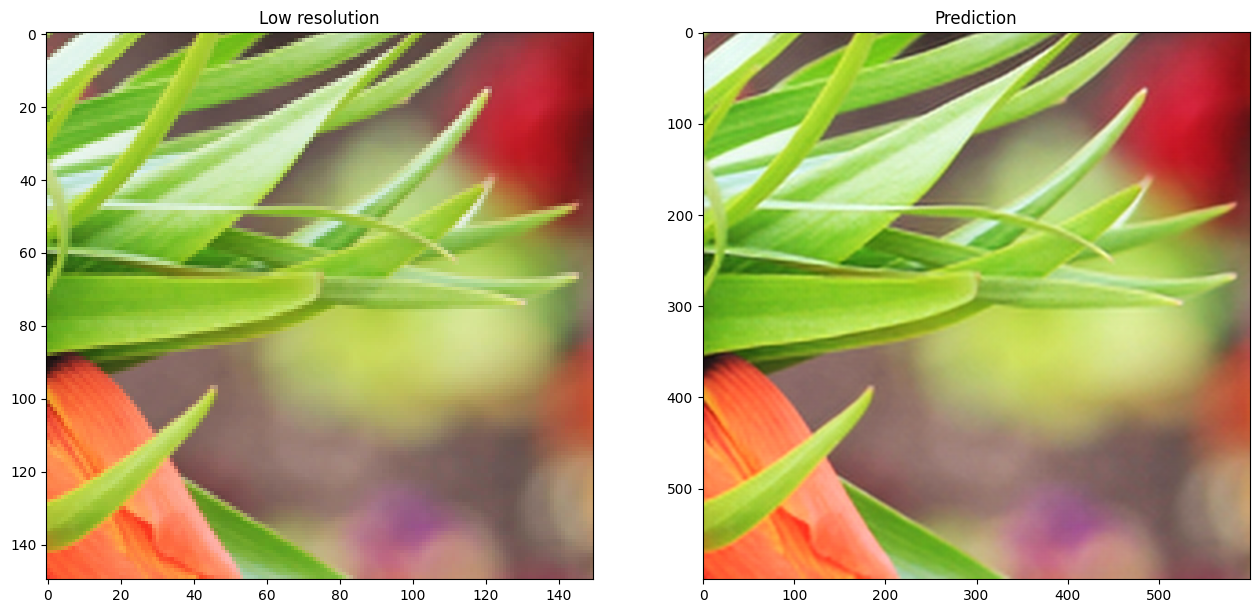

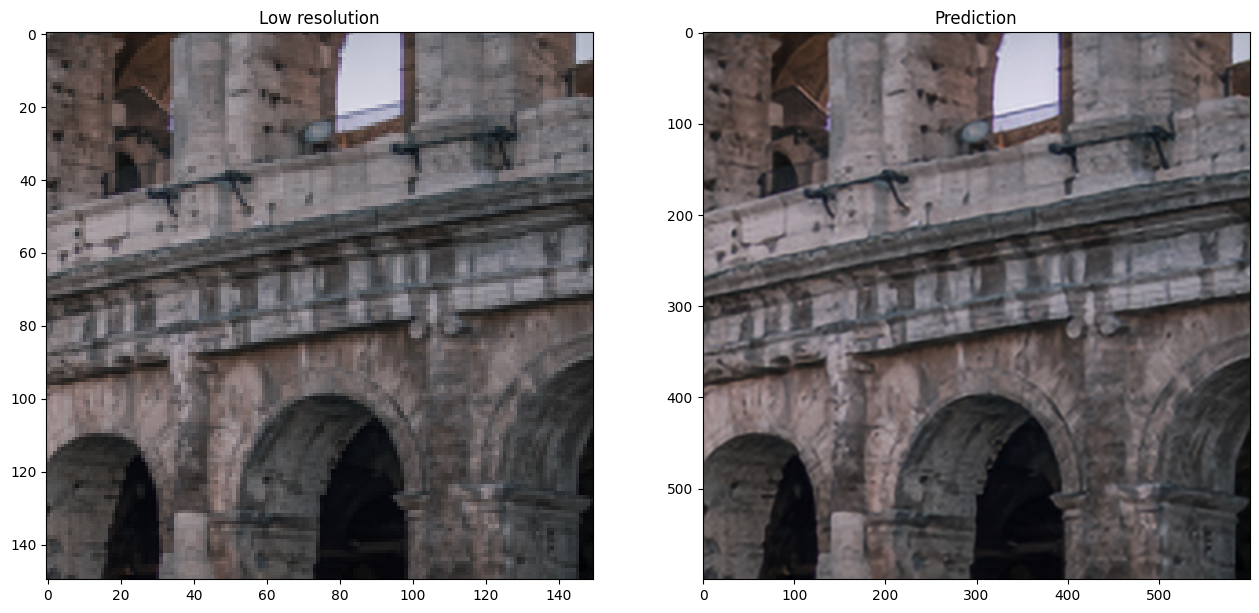

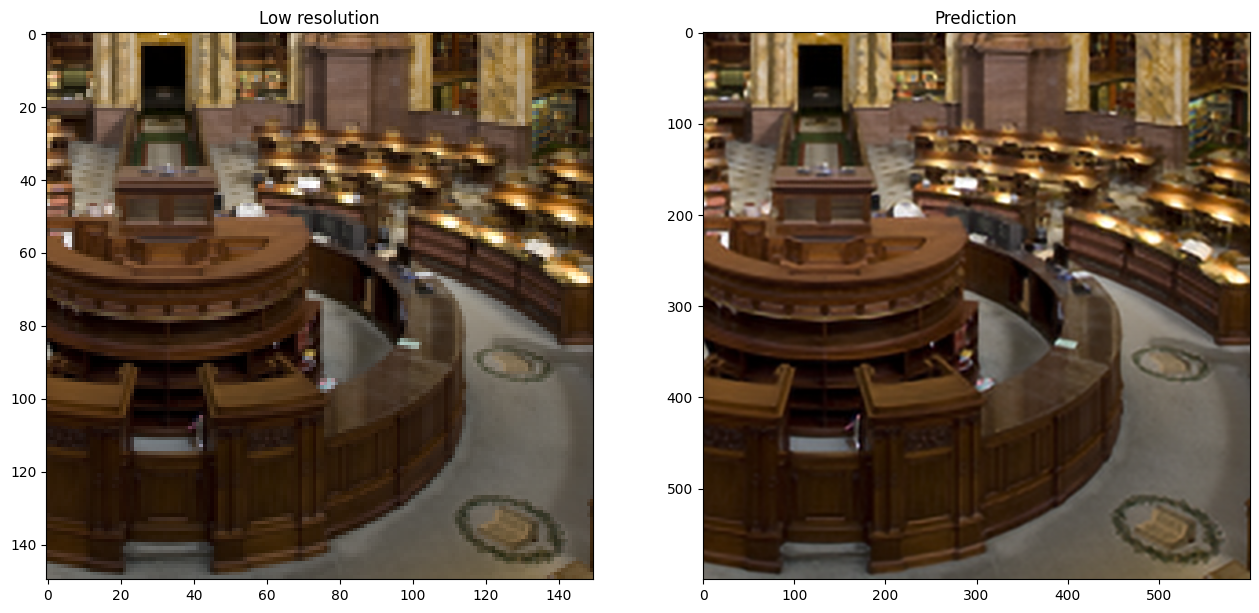

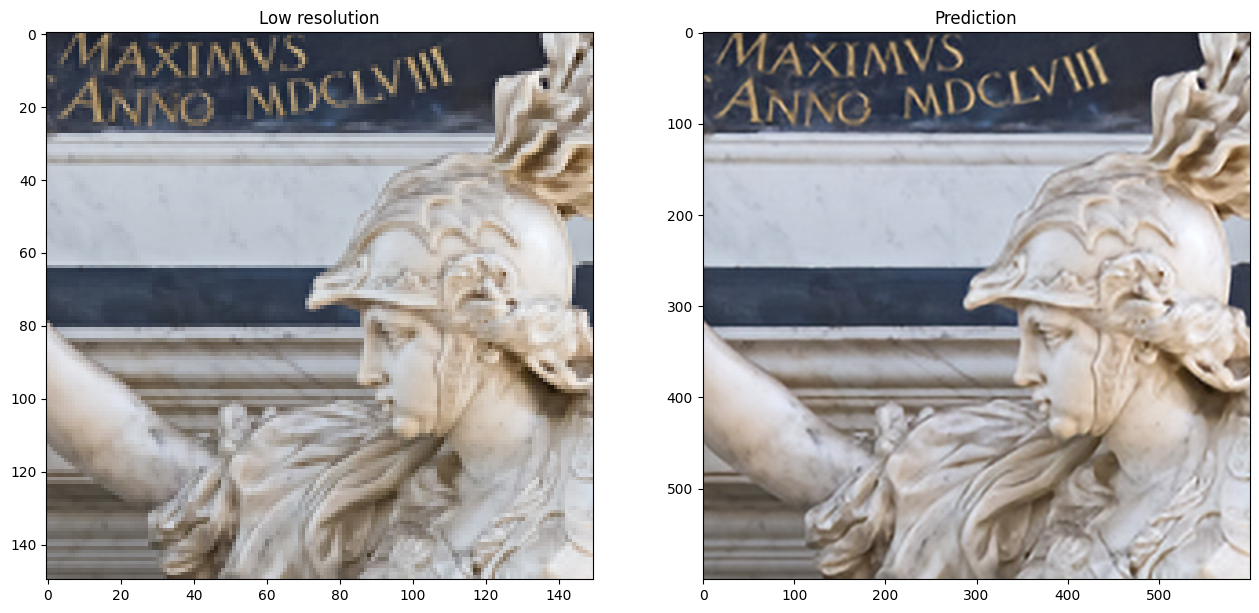

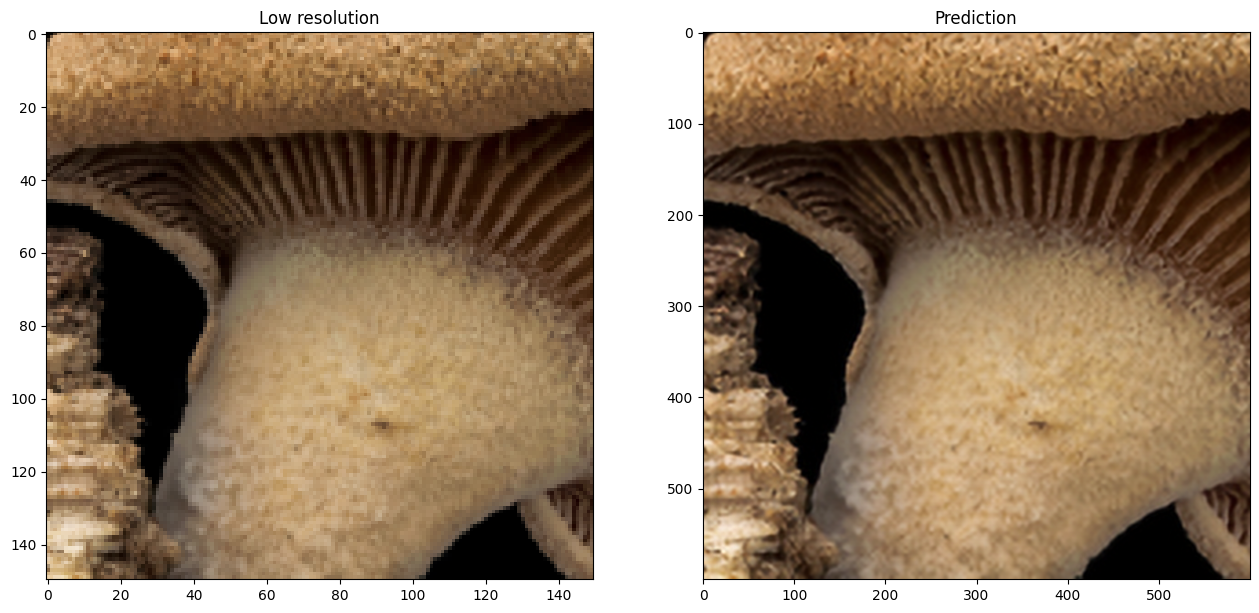

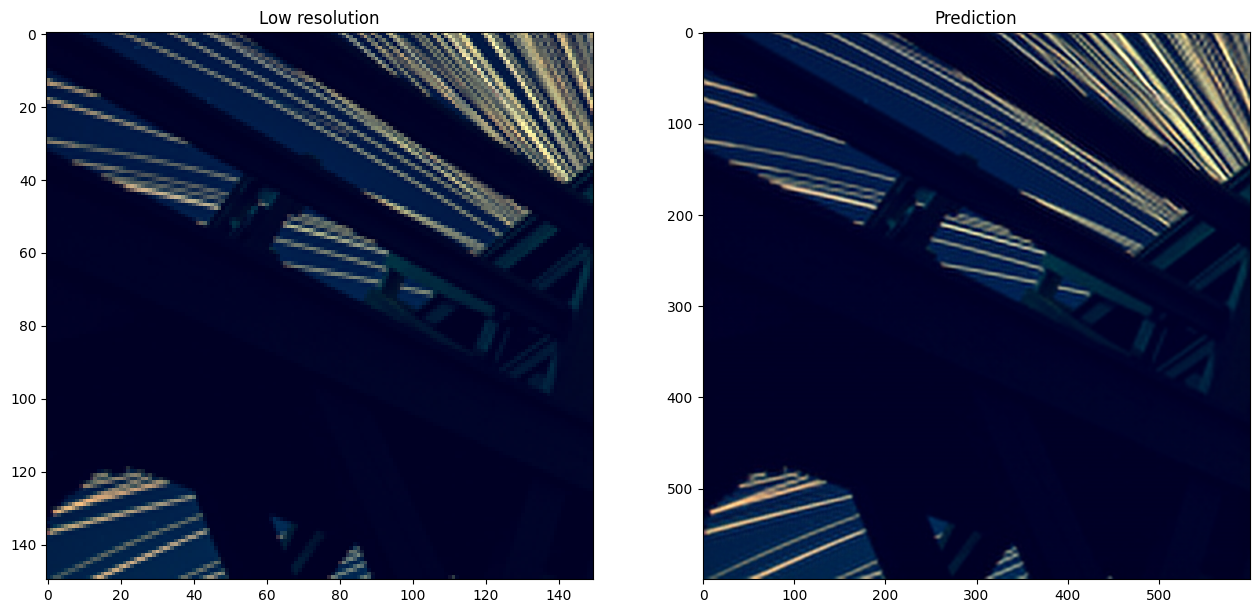

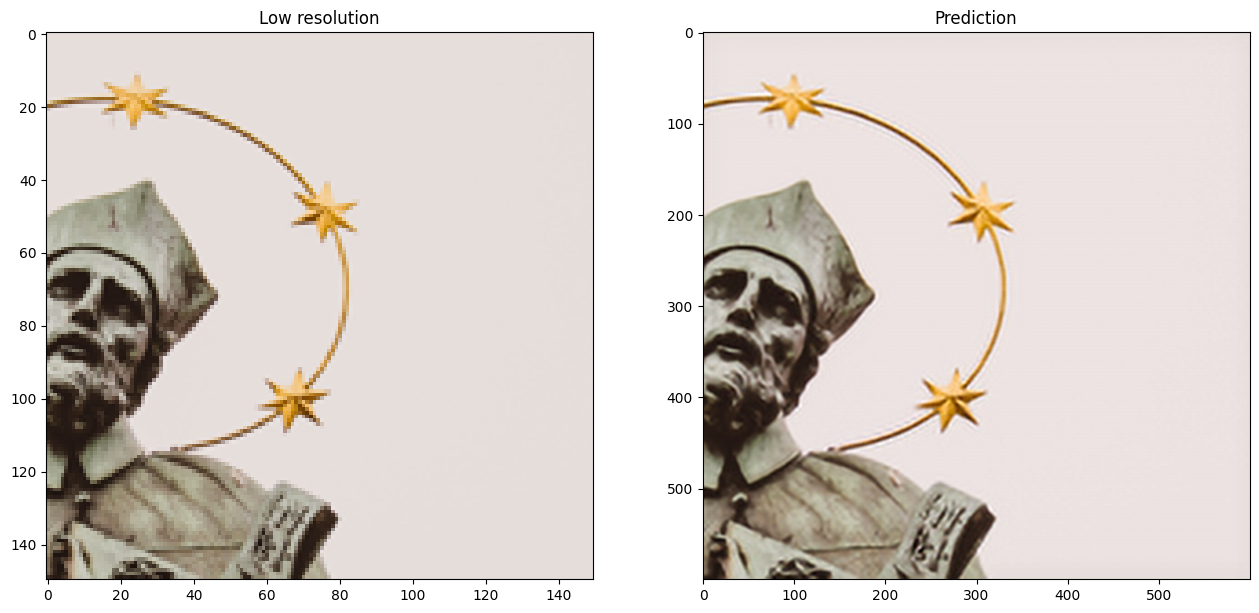

In [15]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)